# Raw data visualization
This notebook is to show you how to visualize the data that we are inputing into the model.

The raw data is contained in `MDSINE2_Paper/datasets/gibson`. 

The pickle files that you need will be in the directory `MDSINE2_Paper/processed_data`. This processing is used to collapse the ASVs into OTUs, perform alignments, phylogenetic placements, and taxonomy assignment.



This tutorial is about working with and visualizing our data and getting it ready for inference. For your data, you can go onto the next tutorial.

In [1]:
%matplotlib inline

import mdsine2 as md2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [17]:
# Loading in the preprocessed healthy pickle
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa.pkl')


print('Healthy')
for subj in healthy:
    print(subj.name)
for perturbation in healthy.perturbations:
    print(perturbation)
print('Ulcerative Colitis')
for subj in uc:
    print(subj.name)
for perturbation in uc.perturbations:
    print(perturbation)


Healthy
2
3
4
5
Perturbation High Fat Diet:
	Subject 2: (21.5, 28.5)
	Subject 3: (21.5, 28.5)
	Subject 4: (21.5, 28.5)
	Subject 5: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 2: (35.5, 42.5)
	Subject 3: (35.5, 42.5)
	Subject 4: (35.5, 42.5)
	Subject 5: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 2: (50.5, 57.5)
	Subject 3: (50.5, 57.5)
	Subject 4: (50.5, 57.5)
	Subject 5: (50.5, 57.5)

Ulcerative Colitis
10
6
7
8
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 8: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 8: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 8: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)



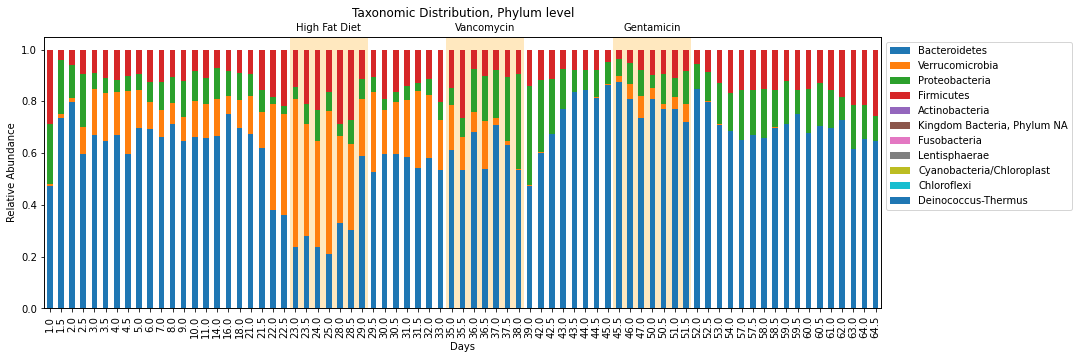

In [23]:
# Make the taxonomic abundance of a subject
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
md2.visualization.taxonomic_distribution_over_time(healthy['2'], taxlevel='phylum', label_formatter='%(phylum)s', ax=ax)

plt.show()

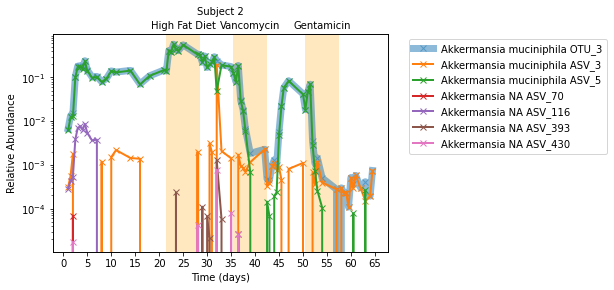

In [24]:
# Visualize the collapse of an OTU
ax = md2.visualization.aggregate_taxa_abundances(subj=healthy['2'], agg=healthy.taxas['OTU_3'])
plt.show()
# We have a script that does this over every subject for every OTU. Run the bash command `./../gibson_dataset/plot_aggregates.sh`

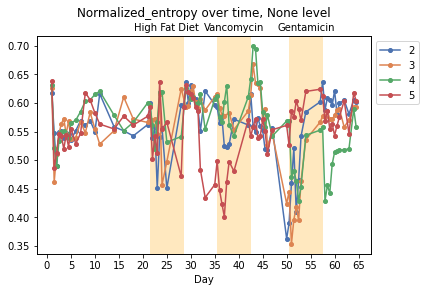

In [25]:
# Alpha diversity
md2.visualization.alpha_diversity_over_time([subj for subj in healthy], 
    metric=md2.diversity.alpha.normalized_entropy)
plt.show()

In [26]:
# SAWAL recreate supplemental figures that you can

In [27]:
# Sawal recreate main figures that you can

In [28]:
# Filtering
# Use consistency filtering
print('Number of OTUs before', len(healthy.taxas))
healthy_filt = md2.consistency_filtering(healthy, dtype='rel',
    threshold=0.0001,
    min_num_consecutive=7,
    min_num_subjects=2,
    colonization_time=5)
print('Number of OTUs after', len(healthy_filt.taxas))

Number of OTUs before 1224
Number of OTUs after 113


113


NOTE these are from a short run. full model runs are much longer
Learned a0 1.1723231422583896e-13
Learned a1 0.06193025254739532


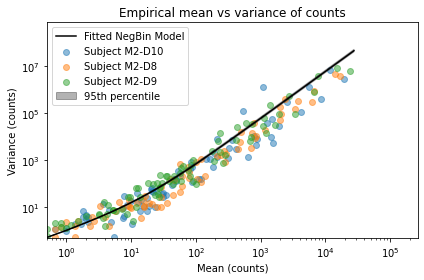

In [29]:
# Negative binomial
# load replicates
reps =  md2.Study.load('../processed_data/gibson_replicates_agg_taxa.pkl')
# Filter like healthy
to_delete = []
for taxa in reps.taxas:
    if taxa.name not in healthy_filt.taxas:
        to_delete.append(taxa.name)
reps.pop_taxas(to_delete)
print(len(reps.taxas))

# Load parameters, basepath is a temporary folder because we will run the shell scripts to generate our actual data
params = md2.config.NegBinConfig(seed=0, burnin=100, n_samples=200, ckpt=100, basepath='tmp/negbin')

# Build the graph
mcmc = md2.negbin.build_graph(params=params, graph_name='test negbin', subjset=reps)

# Run inference
mcmc = md2.negbin.run_graph(mcmc, crash_if_error=True)

# Visualize the fit
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc)
fig.tight_layout()

from mdsine2.names import STRNAMES
print('NOTE these are from a short run. full model runs are much longer')
print('Learned a0', md2.summary(mcmc.graph[STRNAMES.NEGBIN_A0])['mean'])
print('Learned a1', md2.summary(mcmc.graph[STRNAMES.NEGBIN_A1])['mean'])

# Run scripts
These scripts mirror our shell scripts in the folder `MDSINE2_Paper/gibson_dataset` but we modify them to be shorter runs that what is done in the actual scripts. The purpose of these is for you to see what is going on within the scripts.

In [30]:
# Assign taxonomy to consensus sequences
# This is called in the script MDSINE2_Paper/gibson_dataset/preprocess_assign_consensus_taxonomy.sh
!python ../gibson_dataset/scripts/assign_taxonomy_for_consensus_seqs.py \
    --rdp-table ../gibson_dataset/files/assign_taxonomy_OTUs/taxonomy_RDP.txt \
    --confidence-threshold 50 \
    --output-basepath ../processed_data

INFO:assign_taxonomy_for_consensus_seqs.146: Parsing RDP
INFO:assign_taxonomy_for_consensus_seqs.150: Replacing healthy
CRITICAL:base.969: OTU_66 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259851584848
	idx: 65
	name: OTU_66
	Aggregates: ['ASV_88', 'ASV_121']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Enterocloster
		species: NA
CRITICAL:base.969: OTU_85 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259852039672
	idx: 84
	name: OTU_85
	Aggregates: ['ASV_115', 'ASV_124']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Ruminococcaceae
		genus: Fournierella
		species: NA
CRITICAL:base.969: OTU_93 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259852130400
	idx: 92
	name: OTU_93
	Aggregates: ['ASV_130', 'ASV_205', 'ASV_326', 'ASV_407']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridia

In [31]:
# plot the agglom
# Takes approximately <1 minute to plot everything in this cell
# This is called in the script MDSINE2_Paper/gibson_dataset/plot_aggregates.sh
# This produces a folder in MDSINE2_Paper/output/aggregate_plots
!python ../gibson_dataset/scripts/plot_otus.py \
    --study ../processed_data/gibson_healthy_agg_taxa.pkl \
    --output-basepath ../output/aggregate_plots/ \
    --top 20
!python ../gibson_dataset/scripts/plot_otus.py \
    --study ../processed_data/gibson_uc_agg_taxa.pkl \
    --output-basepath ../output/aggregate_plots/ \
    --top 20


INFO:assign_taxonomy_for_consensus_seqs.150: Replacing uc
CRITICAL:base.969: OTU_66 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259876795952
	idx: 65
	name: OTU_66
	Aggregates: ['ASV_88', 'ASV_121']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Enterocloster
		species: NA
CRITICAL:base.969: OTU_85 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259876469224
	idx: 84
	name: OTU_85
	Aggregates: ['ASV_115', 'ASV_124']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Ruminococcaceae
		genus: Fournierella
		species: NA
CRITICAL:base.969: OTU_93 taxonomy does not agree
CRITICAL:base.970: OTU
	id: 2259876575776
	idx: 92
	name: OTU_93
	Aggregates: ['ASV_130', 'ASV_205', 'ASV_326', 'ASV_407']
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Roseburia
		species: f

INFO:plot_otus.36: Subject 2
INFO:plot_otus.42: taxa 0/1224
INFO:plot_otus.42: taxa 1/1224
INFO:plot_otus.42: taxa 2/1224
INFO:plot_otus.42: taxa 3/1224
INFO:plot_otus.42: taxa 4/1224
INFO:plot_otus.42: taxa 5/1224
INFO:plot_otus.42: taxa 6/1224
INFO:plot_otus.42: taxa 7/1224
INFO:plot_otus.42: taxa 8/1224
INFO:plot_otus.42: taxa 9/1224
INFO:plot_otus.42: taxa 10/1224
INFO:plot_otus.42: taxa 11/1224
INFO:plot_otus.42: taxa 13/1224
INFO:plot_otus.42: taxa 14/1224
INFO:plot_otus.42: taxa 15/1224
INFO:plot_otus.42: taxa 17/1224
INFO:plot_otus.42: taxa 18/1224
INFO:plot_otus.42: taxa 19/1224
INFO:plot_otus.36: Subject 3
INFO:plot_otus.42: taxa 0/1224
INFO:plot_otus.42: taxa 1/1224
INFO:plot_otus.42: taxa 2/1224
INFO:plot_otus.42: taxa 3/1224
INFO:plot_otus.42: taxa 4/1224
INFO:plot_otus.42: taxa 5/1224
INFO:plot_otus.42: taxa 6/1224
INFO:plot_otus.42: taxa 7/1224
INFO:plot_otus.42: taxa 8/1224
INFO:plot_otus.42: taxa 9/1224
INFO:plot_otus.42: taxa 10/1224
INFO:plot_otus.42: taxa 11/1224
IN

In [32]:
# plot subtrees
# This takes approximately 1.5 minutes
# This is called in the script MDSINE2_Paper/gibson_dataset/plot_phylogenetic_subtrees.sh
# This produces a folder in MDSINE2_Paper/output/subtrees
!python ../gibson_dataset/scripts/plot_phylogenetic_subtrees.py \
    --study ../processed_data/gibson_healthy_agg_taxa.pkl \
    --output-basepath ../output/subtrees/ \
    --tree ../gibson_dataset/files/phylogenetic_placement_OTUs/phylogenetic_tree_full_taxid.nhx \
    --seq-info ../gibson_dataset/files/subtrees/RDP-11-5_BA_TS_info.tsv \
    --sep \t \
    --family-radius-factor 1.5 \
    --top 20

family is not defined for OTU_48
family is not defined for OTU_71
family is not defined for OTU_88
family is not defined for OTU_151
family is not defined for OTU_152
family is not defined for OTU_159
family is not defined for OTU_164
family is not defined for OTU_167
family is not defined for OTU_201
family is not defined for OTU_213
family is not defined for OTU_230
family is not defined for OTU_235
family is not defined for OTU_250
family is not defined for OTU_265
family is not defined for OTU_283
family is not defined for OTU_286
family is not defined for OTU_318
family is not defined for OTU_321
family is not defined for OTU_329
family is not defined for OTU_332
family is not defined for OTU_349
family is not defined for OTU_352
family is not defined for OTU_353
family is not defined for OTU_354
family is not defined for OTU_360
family is not defined for OTU_361
family is not defined for OTU_368
family is not defined for OTU_372
family is not defined for OTU_382
family is not def

INFO:plot_phylogenetic_subtrees.43: Making distance matrix
INFO:plot_phylogenetic_subtrees.50: Read genbank file
INFO:plot_phylogenetic_subtrees.53: get families of reference seqs
INFO:plot_phylogenetic_subtrees.72: 0/1224 - nan
DEBUG:plot_phylogenetic_subtrees.81: clostridiaceae_1 NOT IN REFERENCE TREE
INFO:plot_phylogenetic_subtrees.72: 100/1224 - 0.6096580723567278
DEBUG:plot_phylogenetic_subtrees.81: clostridiaceae_1 NOT IN REFERENCE TREE
DEBUG:plot_phylogenetic_subtrees.81: clostridiaceae_1 NOT IN REFERENCE TREE
DEBUG:plot_phylogenetic_subtrees.81: clostridiales_incertae_sedis_xiii NOT IN REFERENCE TREE
DEBUG:plot_phylogenetic_subtrees.81: clostridiaceae_1 NOT IN REFERENCE TREE
INFO:plot_phylogenetic_subtrees.72: 200/1224 - 0.621202761478475
DEBUG:plot_phylogenetic_subtrees.81: clostridiales_incertae_sedis_xiii NOT IN REFERENCE TREE
DEBUG:plot_phylogenetic_subtrees.81: clostridiales_incertae_sedis_xiii NOT IN REFERENCE TREE
DEBUG:plot_phylogenetic_subtrees.81: clostridiaceae_1 NOT

family is not defined for OTU_732
family is not defined for OTU_734
family is not defined for OTU_739
family is not defined for OTU_741
family is not defined for OTU_761
family is not defined for OTU_763
family is not defined for OTU_769
family is not defined for OTU_770
family is not defined for OTU_794
family is not defined for OTU_800
family is not defined for OTU_828
family is not defined for OTU_831
family is not defined for OTU_843
family is not defined for OTU_851
family is not defined for OTU_856
family is not defined for OTU_857
family is not defined for OTU_867
family is not defined for OTU_873
family is not defined for OTU_879
family is not defined for OTU_881
family is not defined for OTU_899
family is not defined for OTU_905
family is not defined for OTU_949
family is not defined for OTU_957
family is not defined for OTU_969
family is not defined for OTU_975
family is not defined for OTU_976
family is not defined for OTU_982
family is not defined for OTU_995
family is not 


	Aggregates: ['ASV_2', 'ASV_7', 'ASV_8', 'ASV_69', 'ASV_92']
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: fragilis/ovatus
INFO:plot_phylogenetic_subtrees.154: -------------------------
INFO:plot_phylogenetic_subtrees.153: 

Looking at 2, OTU
	id: 2259852089160
	idx: 2
	name: OTU_3
	Aggregates: ['ASV_3', 'ASV_5', 'ASV_70', 'ASV_116', 'ASV_393', 'ASV_430']
	taxonomy:
		kingdom: Bacteria
		phylum: Verrucomicrobia
		class: Verrucomicrobiae
		order: Verrucomicrobiales
		family: Akkermansiaceae
		genus: Akkermansia
		species: muciniphila
INFO:plot_phylogenetic_subtrees.154: -------------------------
INFO:plot_phylogenetic_subtrees.153: 

Looking at 2, OTU
	id: 2259851585968
	idx: 3
	name: OTU_4
	Aggregates: ['ASV_4', 'ASV_237']
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: 

In [33]:
# Filter the OTUs using consistency filtering
# This is called in the script MDSINE2_Paper/gibson_dataset/preprocessing_filtering.sh
!python ../step_2_filtering.py \
    --dataset ../processed_data/gibson_healthy_agg_taxa.pkl \
    --outfile ../processed_data/gibson_healthy_agg_taxa_filtered.pkl \
    --dtype rel \
    --threshold 0.0001 \
    --min-num-consecutive 7 \
    --min-num-subjects 2 \
    --colonization-time 5
!python ../step_2_filtering.py \
    --dataset ../processed_data/gibson_uc_agg_taxa.pkl \
    --outfile ../processed_data/gibson_uc_agg_taxa_filtered.pkl \
    --dtype rel \
    --threshold 0.0001 \
    --min-num-consecutive 7 \
    --min-num-subjects 2 \
    --colonization-time 5

# Learn negative binomial dispersion parameters
!python ../gibson_dataset/scripts/filter_replicates_like_other_dataset.py \
    --replicate-dataset ../processed_data/gibson_replicates_agg_taxa.pkl \
    --like-other ../processed_data/gibson_healthy_agg_taxa_filtered.pkl \
    --output-basepath ../processed_data/gibson_replicates_agg_taxa_filtered.pkl


		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: salyersiae
INFO:plot_phylogenetic_subtrees.154: -------------------------
INFO:plot_phylogenetic_subtrees.153: 

Looking at 2, OTU
	id: 2259774952784
	idx: 8
	name: OTU_9
	Aggregates: ['ASV_12', 'ASV_193']
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: NA
INFO:plot_phylogenetic_subtrees.154: -------------------------
INFO:plot_phylogenetic_subtrees.153: 

Looking at 2, OTU
	id: 2259852091232
	idx: 9
	name: OTU_10
	Aggregates: ['ASV_13', 'ASV_66', 'ASV_106']
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: uniformis
INFO:plot_phylogenetic_subtrees.154: -------------------------
INFO:plot_phylogenetic_subtrees.153: 

Looking at 2, OTU
	id: 2259851585408
	idx: 10
	name: OTU_11
	Aggregates: ['ASV_14

113 taxas left in healthy
94 taxas left in uc


In [34]:
# negbin
# This is called in the script MDSINE2_Paper/gibson_dataset/learn_negbin.sh
# This produces a folder in MDSINE2_Paper/output/negbin

!python ../step_3_infer_negbin.py \
    --input ../processed_data/gibson_replicates_agg_taxa_filtered.pkl \
    --seed 0 \
    --burnin 100 \
    --n-samples 200 \
    --checkpoint 100 \
    --multiprocessing 0 \
    --basepath ../output/negbin/

INFO:inference.548: Setting Single Write, Multiple Read Mode
INFO:inference.553: Setting the trace of learned parameters
INFO:inference.554: #######################################
INFO:inference.556: Setting the trace of Negative binomial dispersion a0
INFO:inference.556: Setting the trace of Negative binomial dispersion a1
INFO:inference.556: Setting the trace of Filtering
INFO:inference.558: Setting the trace for diagnostic variables
INFO:inference.559: ##########################################
INFO:inference.427: 

Inference iteration 0/200, time: 0.0
INFO:inference.436: Negative binomial dispersion a0: 1e-10
INFO:inference.436: Negative binomial dispersion a1: 0.1
INFO:inference.436: Filtering: NA
INFO:inference.427: 

Inference iteration 1/200, time: 0.35703134536743164
INFO:inference.436: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.436: Negative binomial dispersion a1: Value: 0.0995044775854393, Acceptance rate: 1.0
INFO:inference.436: Fil

INFO:inference.436: Filtering: no-mp : Time: 0.0200, Acc: [0.566, 0.681, 0.584], data/sec: 16978.15
INFO:inference.427: 

Inference iteration 64/200, time: 0.023033618927001953
INFO:inference.436: Negative binomial dispersion a0: Value: 3.821802776738341e-13, Acceptance rate: 0.16
INFO:inference.436: Negative binomial dispersion a1: Value: 0.06170061187796496, Acceptance rate: 0.4
INFO:inference.436: Filtering: no-mp : Time: 0.0200, Acc: [0.655, 0.566, 0.593], data/sec: 16949.01
INFO:inference.427: 

Inference iteration 65/200, time: 0.0240170955657959
INFO:inference.436: Negative binomial dispersion a0: Value: 3.821802776738341e-13, Acceptance rate: 0.16
INFO:inference.436: Negative binomial dispersion a1: Value: 0.06170061187796496, Acceptance rate: 0.4
INFO:inference.436: Filtering: no-mp : Time: 0.0200, Acc: [0.628, 0.558, 0.558], data/sec: 16939.11
INFO:inference.427: 

Inference iteration 66/200, time: 0.02298426628112793
INFO:inference.436: Negative binomial dispersion a0: Value


Inference iteration 118/200, time: 0.023999929428100586
INFO:inference.436: Negative binomial dispersion a0: Value: 1.1824504045169548e-13, Acceptance rate: 0.02
INFO:inference.436: Negative binomial dispersion a1: Value: 0.0730235287801449, Acceptance rate: 0.36
INFO:inference.436: Filtering: no-mp : Time: 0.0200, Acc: [0.619, 0.673, 0.602], data/sec: 16950.82
INFO:inference.427: 

Inference iteration 119/200, time: 0.023031234741210938
INFO:inference.436: Negative binomial dispersion a0: Value: 1.1824504045169548e-13, Acceptance rate: 0.02
INFO:inference.436: Negative binomial dispersion a1: Value: 0.07102992555644538, Acceptance rate: 0.36
INFO:inference.436: Filtering: no-mp : Time: 0.0200, Acc: [0.584, 0.699, 0.584], data/sec: 16949.21
INFO:inference.427: 

Inference iteration 120/200, time: 0.0240020751953125
INFO:inference.436: Negative binomial dispersion a0: Value: 1.1824504045169548e-13, Acceptance rate: 0.02
INFO:inference.436: Negative binomial dispersion a1: Value: 0.0654